In [1]:
# from __future__ import division, print_function, absolute_import
%matplotlib inline
import numpy as np

from phidl import Device, Layer, LayerSet, make_device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu

import gdspy
# import customed geolib
%copy ..\photonic.py
import photonic as ph
import matplotlib.pyplot as plt

        1 file(s) copied.


In [6]:
# taper extending for dicing
def dic_taper(port, # port to extend
              length=10, 
              width1=3, # width at port
              width2=1, # end width
              dicL = 4, # length to dice with width2
              layer=0):
    D = Device('dic_taper')
    TP = D << pg.taper(port=port,length=length,width1=width1,width2=width2,layer=layer)
    DIC = D << pg.taper(port=TP.ports[2],length=dicL, width1=width2,width2=width2,layer=layer)
    return D

def ext_allpass(width_rg=1, width_bus=1, radius=30, gap=0.1,lenL=10,lenR=10 ,layer = 0):
    D = Device('ext_allpass')
    RG = D << pg.ring(radius=radius,width=width_rg, angle_resolution=.1,layer = layer)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus,layer = layer).movex(-radius-(width_rg)/2-lenL)
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D

def ext_fourport(width_rg=2, width_bus=1, radius=30, gap1=0.1, gap2=0.1, 
           extL = 100, layer=0):
    D = Device('ext_fourport')
    RG = D << ph.fourport(width_bus=width_bus,width_rg=width_rg,radius=radius, layer=layer)
    RG.ymin = -width_bus*.5

    TP1 = D << pg.taper(port=RG.ports[3],length=radius,width1=width_bus,width2=0,layer=layer)
    
    CN1 = D << pg.connector((TP1.xmax,4*radius),width=width_bus,orientation=0)
    RT1 = D << pr.route_manhattan180(port1=CN1.ports[2],port2=RG.ports[4],layer=layer, radius=.9*radius)

    ET1 = D << pg.taper(port=RG.ports[1],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    ET2 = D << pg.taper(port=RG.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    ET3 = D << pg.taper(port=ET2.ports[2],length=extL,width1=width_bus,width2=width_bus,layer=layer)
    
    D.add_port(name=1, midpoint = (D.xmin,width_bus/2), width = width_bus, orientation = 180)
    D.add_port(name=2, midpoint = (D.xmax,width_bus/2), width = width_bus, orientation = 0)
    D.add_port(name=3, midpoint = (D.xmax,D.ymax-width_bus/2), width = width_bus, orientation = 0)

    return D.flatten()


# ring composed of two unconcentric round
def asym_ring(dx = .2, radius = 10, width = 0.5, angle_resolution = 1, layer = 0):
    assert dx < width
    D = Device(name = 'new_ring')
    inner_radius = radius - width/2
    outer_radius = radius + width/2
    angle = np.linspace(0, 360, np.ceil(360/angle_resolution))
    angle.sort()
    t=angle*np.pi/180
    inner_points_x = (inner_radius*np.cos(t)+dx).tolist()
    inner_points_y = (inner_radius*np.sin(t)).tolist()
    outer_points_x = (outer_radius*np.cos(t)).tolist()
    outer_points_y = (outer_radius*np.sin(t)).tolist()
    xpts = inner_points_x + outer_points_x[::-1]
    ypts = inner_points_y + outer_points_y[::-1]
    D.add_polygon(points = (xpts,ypts), layer = layer)
    return D

def asym_allpass(width_rg=1, width_bus=1, dx = 0.1, radius=30, gap=0.1, layer=0):
    D = Device('asym_allpass')
    RG = D << asym_ring(dx = dx, radius=radius,width=width_rg, layer=layer) 
    BUS = D << ph.waveguide(length=2*radius+width_rg,width=width_bus, layer=layer).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D

In [4]:
WG_LAY = 1
TP_LAY = 2
LB_LAY = 3
MK_LAY = 4

DIC = 8e2
cellSize = np.array((10e3,10e3))
cellH, cellW = cellSize

# taper length & taper width, width of bus -> width of taper
lTp = 500
wTp = .3

## allpass mrr

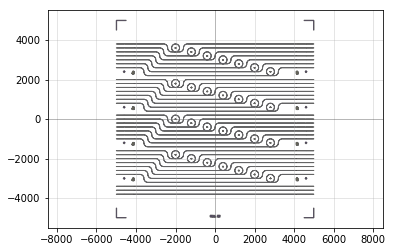

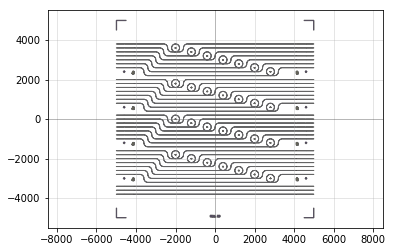

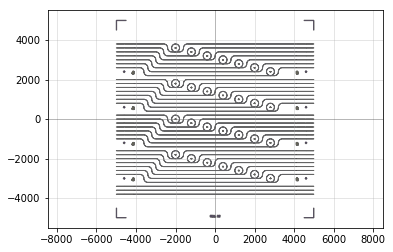

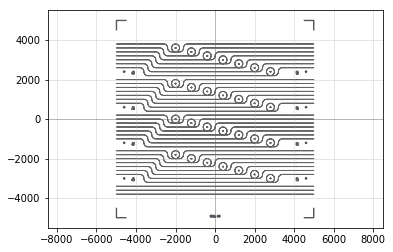

In [5]:
for xx in range(2):
    for yy in range(2):
        wBus = 1.5
        CELL_NUM = 22+10*xx+yy
        wTp = .3 + yy*.3
        cellGDS = Device(f'cell{CELL_NUM}')

        # sweep the ring width between groups of devices

        devLen = cellW-DIC-2*lTp

        # ring radius
        rRg = 200

        # horizontal and vertical dist. per device
        HD = 4*rRg
        VD = rRg

        gpNum  = 4
        gapPeriod = .05

        for k in range(gpNum):

            wRg = 1.5 + .8*xx + .2*k    

            devNum = 7 # num of MRR dev

            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            LB = Device(f'LB{k}')

            for i in range(devNum):
                gap = gapPeriod*i+0.1
                MRR = D << ext_allpass(width_bus=wBus,
                                   width_rg=wRg,radius=rRg,
                                   gap=gap,
                                   lenL=i*HD+i*rRg,
                                   lenR=0,
                                  layer=WG_LAY).move((offset+HD*i,-VD*i))
                LB << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

                # tp port
                CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
                CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

                TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

            #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
                RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)

            markNum = 1
            markDist = 300
            markSize = 100
            markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -rRg))
            markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-rRg))
            D << LB
            cellGDS << D.flatten().movey(VD*(devNum+2)*k)

        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

        for i in range(3):
            cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  pg.basic_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

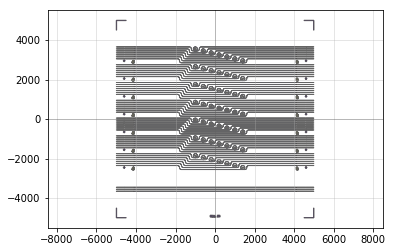

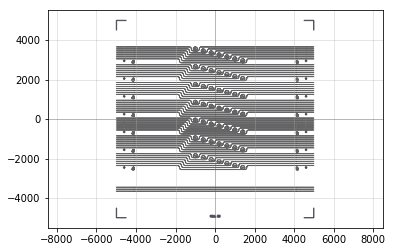

In [6]:
# aa
for yy in range(2):
    CELL_NUM = 24 + yy
    wTp = .3 + yy*.3

    wBus = 1.5
    cellGDS = Device(f'cell{CELL_NUM}')

    # sweep the ring width between groups of devices

    devLen = cellW-DIC-2*lTp

    # ring radius
    rRg = 100

    # horizontal and vertical dist. per device
    HD = 4*rRg
    VD = rRg

    gpNum  = 7
    gapPeriod = .05

    for k in range(gpNum):

        wRg = 1.5 + .2*k    

        devNum = 7 # num of MRR dev

        # x-axis shift
        offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

        D = Device(f'GP{k}')
        LB = Device(f'LB{k}')

        for i in range(devNum):
            gap = gapPeriod*i+0.1
            MRR = D << ext_allpass(width_bus=wBus,
                               width_rg=wRg,radius=rRg,
                               gap=gap,
                               lenL=i*HD+i*rRg,
                               lenR=0,
                              layer=WG_LAY).move((offset+HD*i,-VD*i))
            LB << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

            # tp port
            CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
            CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

            TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)

        #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
            RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                          bendType='circular',radius=rRg,layer=WG_LAY)
            RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                          bendType='circular',radius=rRg,layer=WG_LAY)

        markNum = 1
        markDist = 300
        markSize = 100
        markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -rRg))
        markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -rRg))
        LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                          layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-rRg))
        LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                          layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-rRg))
        D << LB
        cellGDS << D.flatten().movey(VD*(devNum+2)*k)

    def BAR():
        D = Device('BAR')
        wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
        tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        return D.flatten()

    for i in range(3):
        cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


    cellGDS.move(-cellGDS.center)

    cellGDS <<  pg.basic_die(size=cellSize, text_size=100,
                             street_length=500, 
                             street_width=20, text_location='S',
                             die_name=f'CELL {CELL_NUM}',
                             draw_bbox=False,
                             layer=MK_LAY)
    qp(cellGDS)
    cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## three port

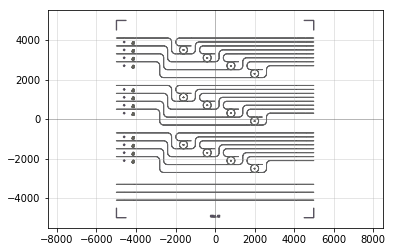

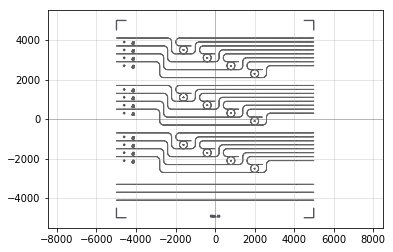

In [11]:
# 
for yy in range(2):
    CELL_NUM = 12 + yy
    wTp = .3 + yy*.3

    wBus = 1.5
    cellGDS = Device(f'cell{CELL_NUM}')

    # sweep the ring width between groups of devices


    # taper length & taper width, width of bus -> width of taper
    lTp = 500

    devLen = cellW-DIC-2*lTp

    # ring radius
    rRg = 200

    # horizontal and vertical dist. per device
    HD = 6*rRg
    VD = 2*rRg

    gpNum  = 3
    gapPeriod = .02

    for k in range(gpNum):

        wRg = 2.3     

        devNum = 4 # num of MRR dev

        # x-axis shift
        offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

        D = Device(f'GP{k}')
        for i in range(devNum):
            gap = gapPeriod*(k*devNum+i) + 0.1
            MRR = D << ext_fourport(width_bus=wBus,
                              width_rg=wRg,radius=rRg,
                              gap1=gap,
                              gap2=gap,
                              extL=(HD+rRg)*i,
                              layer=WG_LAY).movex(offset+HD*i).movey(-VD*i)
            D << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY,
                         justify='center').movex(offset+HD*i).movey(-VD*i+rRg)

            # tp port
            CN1 = D << pg.connector((lTp+DIC*.5, MRR.ysize), width=wBus).movey(-VD*i)
            CN2 = D << pg.connector((devLen+lTp+DIC*.5,MRR.ysize-rRg), width=wBus).movey(-VD*i)
            CN3 = D << pg.connector((devLen+lTp+DIC*.5,MRR.ysize), width=wBus).movey(-VD*i)

            TP1 = D << dic_taper(port=CN1.ports[2],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            TP2 = D << dic_taper(port=CN2.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            TP3 = D << dic_taper(port=CN3.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)

            RT1 = D << pr.route_manhattan(port1=CN1.ports[1],port2=MRR.ports[1],
                                          bendType='circular',radius=rRg,layer=WG_LAY)
            RT2 = D << pr.route_manhattan(port1=CN2.ports[2],port2=MRR.ports[2],
                                          bendType='circular',radius=rRg,layer=WG_LAY)
            RT3 = D << pr.route_basic(port1=CN3.ports[2],port2=MRR.ports[3],layer=WG_LAY)

            mark1 = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CN1.ports[1]).move((-lTp,-rRg))
            D << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}',
                         layer=LB_LAY, justify='right', size=20).move(CN1.ports[1]).movey(-rRg)
        cellGDS << D.flatten().movey(VD*(devNum+2)*k)



    def BAR():
        D = Device('BAR')
        wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
        tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        return D.flatten()

    for i in range(3):
        cellGDS << pg.copy(BAR()).movey(-i*VD-1.8e3)


    cellGDS.move(-cellGDS.center)

    cellGDS <<  pg.basic_die(size=cellSize, text_size=100,
                             street_length=500, 
                             street_width=20, text_location='S',
                             die_name=f'CELL {CELL_NUM}',
                             draw_bbox=False,
                             layer=MK_LAY)
    qp(cellGDS)
    cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## spiral

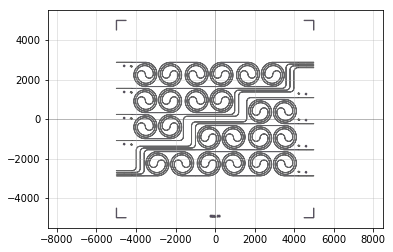

'cell/cell34.gds'

In [13]:
# cell 34
cellGDS = Device('cellSpiral')

DIS = 90
BR = 200
rRg = 200
wBus = 1.5

lTp = 400
wTp = .3

devLen = cellW-DIC-2*lTp

def ext_sp(bent = 20, width = 0.5, n = 1, distance = 10, angle_resolution = 1, layer = 1):
    D = Device('ext_sp')
    AP = D << ph.archimedes(bent=bent,width=width,n=n,distance=distance,angle_resolution=angle_resolution,layer=layer)
    D << pg.taper(port=AP.ports[2],length=AP.xmax+distance/2, layer=layer)
    D << pg.taper(port=AP.ports[1],length=AP.xmax+distance, layer=layer)
    D.xmax = 0
    D << pg.deepcopy(D).reflect((0,1))
    D.add_port(name = 1, midpoint = [D.xmin,D.ymax-width/2], width = width, orientation = 180)
    D.add_port(name = 2, midpoint = [D.xmax,D.ymax-width/2], width = width, orientation = 0)
    return D.flatten()

doublet = ext_sp(bent=rRg,
                     width=wBus,
                     n=1,
                     distance=DIS,
                     angle_resolution=0.5,
                     layer=WG_LAY)
doublet.xmin=0
doublet.ymin=0

spNum = 4

extL = devLen-(spNum-1)*doublet.xsize

def ss(n=1):
    D = Device('ss')
    for i in range(n):
        c1 = pg.connector(midpoint=((doublet.xmax+BR)*i,(doublet.ymax)*i),width=wBus,orientation=0)
        c2 = pg.connector(midpoint=((doublet.xmax+BR)*(i+1),(doublet.ymax)*(i+1)),width=wBus,orientation=0)
        D << pr.route_manhattan(port1=c1.ports[1],port2=c2.ports[2], radius=BR,layer=WG_LAY)
    try:
        D << pg.taper(port=c2.ports[1],width1=wBus,width2=wBus,length=extL-n*BR,layer=WG_LAY)
    except UnboundLocalError:
        D << ph.waveguide(width=wBus,length=extL,layer=WG_LAY)
    return D.flatten()


def sssp(n=2,spNum=3):
    D = Device('sssp')
    assert n <= spNum
    for i in range(n):
        D << pg.copy(doublet).movex(doublet.xmax*i)
    D << ss(spNum-n).move((doublet.xmax*n,doublet.ymax))
    D.add_port(name = 1, midpoint = [D.xmin,doublet.ymax-wBus/2], width = wBus, orientation = 180)
    D.add_port(name = 2, midpoint = [D.xmax,D.ymax-wBus/2], width = wBus, orientation = 0)
    return D.flatten()


for i in range(spNum):
    sp_tmp = Device('sp_tmp')
    spU = sp_tmp << sssp(i,spNum-1).movey((doublet.ymax+DIS)*i)
#     spD = sp_tmp << sssp(i,spNum-1).movey((doublet.ymax+DIS)*i).rotate(180).move((spU.xsize,(doublet.ysize)*spNum))
    tp1 = sp_tmp << dic_taper(port=spU.ports[1],length=lTp,dicL=DIC/2,
                      width1=wBus, width2=wTp, layer=TP_LAY)
    tp2 = sp_tmp << dic_taper(port=spU.ports[2],length=lTp,dicL=DIC/2,
                      width1=wBus, width2=wTp, layer=TP_LAY)
    mark = sp_tmp << pg.cross(length=100, width=20, layer=MK_LAY).move(spU.ports[1]).move((-lTp, -2*DIS))
    devL = spU.area()/wBus
    sp_tmp << pg.text(text=f'L {devL*1e-3:.2f}\nW {wBus}', 
                      layer=LB_LAY, justify='right', size=20).move(spU.ports[1]).move((0,-rRg))
#     LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
#                       layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-rRg))
    
    cellGDS << sp_tmp




cellGDS.move(-cellGDS.center)
cellGDS << pg.copy(cellGDS).rotate(180).movey(-doublet.ymax*spNum*.5+900)
cellGDS.move(-cellGDS.center)

cellGDS <<  pg.basic_die(size=cellSize, text_size=100,
                         street_length=500, 
                         street_width=20, text_location='S',
                         die_name='CELL 34',
                         draw_bbox=False,
                         layer=MK_LAY)
qp(cellGDS)
cellGDS.flatten().write_gds('cell/cell34.gds')

## generator

In [14]:
waferGDS = Device('waferGDS')

for x in range(6):
    for y in range(6):
#         cellFile = f'cell11.gds'
        cellFile = f'cell/cell{x}{y}.gds'
        try:
            waferGDS << pg.import_gds(filename=cellFile,flatten=True).move((cellW*(x-2.5),cellH*(y-2.5)))
        except FileNotFoundError:
            pass

waferGDS << pg.ring(radius=65e3*.5,layer=5)
waferGDS << pg.ring(radius=100e3*.5,layer=5)

# waferGDS << pg.bbox( ((0,0),(1e3,1e3)) )
waferGDS.write_gds('view_ntt.gds')

'view_ntt.gds'

In [38]:
%cd cell/ 
%copy cell00.gds cell14.gds
%cd ..

[WinError 2] The system cannot find the file specified: 'cell/'
C:\Users\fibom\Documents\GDS\190924-NTT\cell
        1 file(s) copied.
C:\Users\fibom\Documents\GDS\190924-NTT


In [11]:
for i in range(6):
    for j in range(6):
        cellGDS = Device('NA')
        cellGDS <<  pg.basic_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {i}{j}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        cellGDS.flatten().write_gds(f'cell/cell{i}{j}.gds')

## playground

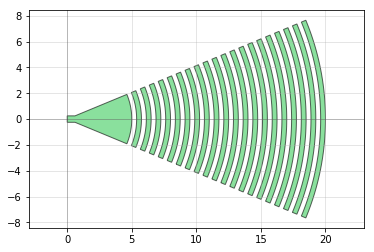

In [2]:


D = Device('view')

# MRR = D << ext_fourport(gap1=1,gap2=2)
# D << pg.taper(port=MRR.ports[3])
# D << pg.grating()
D << ph.arc_grating()
D.flatten().write_gds('view.gds', auto_rename= False)
qp(D)


C:\Programs\conda\envs\gds\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


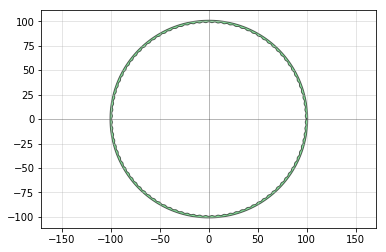

C:\Programs\conda\envs\gds\lib\site-packages\gdspy\__init__.py:6278: UserWarning: [GDSPY] Polygons with more than 8190 are not supported by the official GDSII specification.  This GDSII file might not be compatible with all readers.
  outfile.write(cell.to_gds(self.unit / self.precision))


'view.gds'

In [17]:
from phidl.geometry import *

def tooth_ring(radius = 100, width = 2, amp_factor = 0.002, tooth_num = 360, angle_resolution = .01, layer = 0):
    D = Device(name = 'new_ring')
    inner_radius_int = radius - width/2
    outer_radius = radius + width/2
    angle = np.linspace(0, 360, np.ceil(360/angle_resolution))
    angle.sort()
    t=angle*np.pi/180
    inner_radius = inner_radius_int*(1 + amp_factor*width*cos(t*100))
    inner_points_x = (inner_radius*cos(t)).tolist()
    inner_points_y = (inner_radius*sin(t)).tolist()
    outer_points_x = (outer_radius*cos(t)).tolist()
    outer_points_y = (outer_radius*sin(t)).tolist()
    xpts = inner_points_x + outer_points_x[::-1]
    ypts = inner_points_y + outer_points_y[::-1]
    D.add_polygon(points = (xpts,ypts), layer = layer)
    return D

D = Device('test')

D << tooth_ring(radius=100)

qp(D)

D.flatten().write_gds('view.gds')

In [ ]:
def arc_tapered(radius = 10, width1 = 1, width2 = 2, theta = 45, angle_resolution = 2.5, layer = 0):
    D = Device('arctaper')
    path1 = gdspy.Path(width = width1, initial_point = (0, 0))
    path1.turn(radius = radius, angle = theta*np.pi/180, number_of_points=int(abs(2*theta/angle_resolution)), final_width = width2)
    [D.add_polygon(p, layer = layer) for p in path1.polygons]
    D.add_port(name = 1, midpoint = (0, 0), width = width1, orientation = 180)
    D.add_port(name = 2, midpoint = (path1.x, path1.y), width = width2, orientation = path1.direction*180/np.pi)
    return D

def mrr3pH(width_rg=2, width_bus=1, radius=30, gap1=0.1, gap2=0.1, layer=0):
    D = Device('mrr3p')
    RG = D << ph.ring(radius=radius,width=width_rg, layer=layer).movey(radius)
    BUS = D << ph.waveguide(length=2*radius, width=width_bus, layer=layer).rotate(90)
    RG.xmin = BUS.xmax + gap1
    BT1 = D << pg.turn(angle=90,port=BUS.ports[1],radius=radius,layer=layer)
    BT2 = D << pg.turn(angle=90,port=BUS.ports[2],radius=radius,layer=layer)
    ET1 = D << pg.taper(port=BT1.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    BT2 = D << pg.turn(angle=90,port=ET1.ports[2],radius=radius,layer=layer)
    ET2 = D << pg.taper(port=BT2.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    BT3 = D << pg.turn(angle=-90,port=ET2.ports[2],radius=radius,layer=layer)
    CN1 = D << pg.connector((0,0),width=0, orientation=90)
    CN2 = D << pg.connector((0,2*radius),width=width_bus,orientation=90)
    RT1 = D << pr.route_basic(port1=CN1.ports[1],port2=CN2.ports[2],layer=layer)
    RT1.movex(2*radius+gap1+gap2+width_rg+width_bus)
    BT4 = D << pg.turn(angle=-90,port=RT1.ports[2],radius=radius,layer=layer)
    
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D



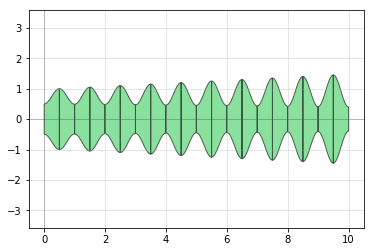

In [74]:
D = Device('ee')

def drum(width1 = 1.2, width2 = 1.0, length=1, ef = 3, layer = 0, resolution = .01):
    D = Device('DRUM')
#     xpts = np.arange(0,length,resolution)
#     ypts = [width1+(width2-width1)/length*t + (width1+width2)*.5*ef*(1+np.sin(t*length*np.pi*2)) for t in xpts]
#     D.add_polygon(points = (xpts,ypts), layer = layer)
    CN1 = pg.connector(midpoint=(0,0),width=width1)
    CN2 = pg.connector(midpoint=(length*.5,0),width=ef)
    CN3 = pg.connector(midpoint=(length,0),width=width2)
    D << pr.route_basic(port1=CN1.ports[1],port2=CN2.ports[2], layer=layer,path_type = 'sine', width_type = 'sine',)
    D << pr.route_basic(port1=CN2.ports[1],port2=CN3.ports[2], layer=layer,path_type = 'sine', width_type = 'sine',)
    
    return D.flatten()
width =[1-0.02*i for i in range(11)]
for i in range(10):   
    D << drum(width1=width[i],width2=width[i+1],ef=2+.1*i).movex(i)

qp(D)

In [18]:
D = Device('CJC')
LB_CEL = Device('LB_CEL')

def ext_allpass(width_rg=1, width_bus=1, radius=30, gap=0.1,lenL=10,lenR=10):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg, angle_resolution=.1)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus).movex(-radius-(width_rg)/2-lenL)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D
w = 1.5 # width of
wBus = 1.5
wRg = w
# wTp = 0.2

devLen = 10000
rRg = 100

HD = 4*rRg
VD = rRg*.8
num = 8 # num of MRR

gapPeriod = .05
offset = devLen/2 - num*HD/2
# margin = 100

for i in range(num):
    gap = gapPeriod*i+0.1
    MRR = D << ext_allpass(width_bus=wBus,
                       width_rg=wRg,radius=rRg, 
                       gap=gap,
                       lenL=i*HD+i*rRg,
                       lenR=0).move((offset+HD*i,-VD*i))
    LB_CEL << pg.text(text='GAP%d' % (1e3*gap), layer=2, justify='right').move((offset+HD*i,-VD*i))
    TPCL = D << pg.connector((0,rRg-VD*i),width=wBus)
    TPCR = D << pg.connector((devLen,rRg-VD*i),width=wBus)
#     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
    RT1 = D << pr.route_manhattan(port1=TPCL.ports[1],port2=MRR.ports[2],
                                  bendType='circular',radius=rRg)
    RT2 = D << pr.route_manhattan(port1=TPCR.ports[2],port2=MRR.ports[1],
                                  bendType='circular',radius=rRg)

mark = [pg.rectangle((100,100), layer=2).move((300*i,-(num)*VD)) for i in range(5)]
mark2 = [pg.rectangle((100,100), layer=2).move((devLen-300*i-100,-(num)*VD)) for i in range(5)]

bar =  ph.waveguide(length=devLen,width=wBus).move((0,-(num+1)*VD))
for i in range(3):
    D << pg.copy(bar).movey(-i*VD)
    
D_out = pg.outline(D, distance=10, layer=1)

for i in (D, D_out):
    i << LB_CEL
    i << tuple(mark)
    i << tuple(mark2)

D.rotate(90)
# D_out.flatten().write_gds('190807-nanofab-mrr-nega.gds')
# D.flatten().write_gds('190807-nanofab-mrr-posi.gds')

Device (name "CJC" (uid 7676),  ports [], aliases [], 0 polygons, 54 references)

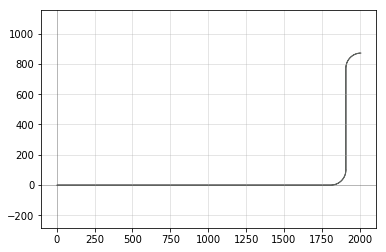

In [168]:
D = Device('bus')

def ss():
    D = Device('ss')
    c1 = pg.connector(midpoint=(0,0),width=1,orientation=0)
    c2 = pg.connector(midpoint=(doublet.xmax,doublet.ymax),width=5,orientation=0)
    D << pr.route_manhattan(port1=c1.ports[1],port2=c2.ports[2], radius=100)
    return(D)

D << ss()

qp(D)

# D.flatten().write_gds('view.gds')

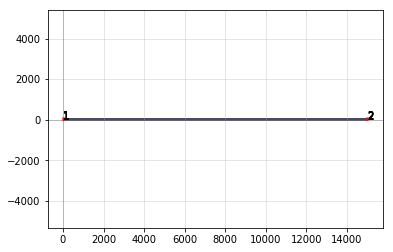

'templates/trench.gds'

In [78]:
# create trenches to test etching rate
D = Device('trench')

w_l = [0.2,0.3,0.4,0.6,1,2,5,10]

mx = 0
for i in range(len(w_l)):
    mx += (w_l[i] + 5)
#     print(mx)
    D << ph.waveguide(width=w_l[i],length=15e3, layer=1).movey(mx)

qp(D)
D.write_gds('templates/trench.gds')

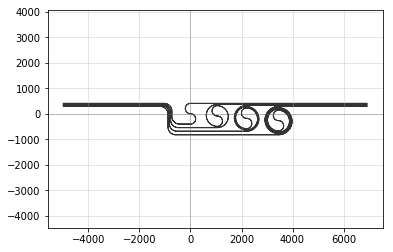

In [14]:
D = Device('SEMI')
D_b = Device('lb')
width = 1.5
xs = 50
ys = 90
for i in range(4):
    CEL = Device('CEL')
    foo = 1e3+i*xs
    SS = CEL << ph.semi_spiral(bend=430,shift=xs,width=width,layer=1, n=i).move((foo*i,-ys*i))
    EXR = CEL << ph.extend(port=SS.ports[2],length=6.5e3-(foo+xs)*i)
    EXL = CEL << ph.extend(port=SS.ports[1],length=(foo)*i)
    CN = pg.connector((-5e3,SS.ports[2].midpoint[1]),width,orientation=0)
    CEL << pr.route_manhattan(CN.ports[1],EXL.ports[2],bendType='circular',radius=300)    
    L = CEL.area()/width
    D_b << pg.text(text='WL%.2f'% L, position=((foo*i,100-ys*i)))
    D << CEL
#       D.area()/width

D_out = pg.outline(D,distance=10)
D_out << D_b

D_out.flatten().write_gds('templates/semicircle-spiral_align.gds')
qp(D)

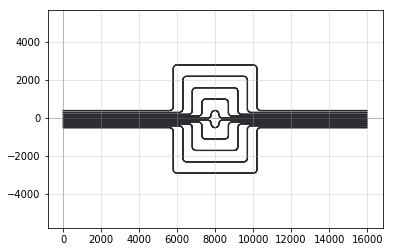

In [61]:
D = Device('array')

def swing(length=1.3e3, height=100, bend=200):
    D = Device('swing')
    subL = length - height - 2*bend
    assert subL > 100
    WG1 = D << ph.waveguide(length=subL,width=1.5)
    BD1 = D << pg.turn(port=WG1.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG2 = D << ph.extend(port=BD1.ports[2],length=height)
    BD2 = D << pg.turn(port=WG2.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG3 = D << ph.extend(port=BD2.ports[2],length=2*height)
    BD3 = D << pg.turn(port=WG3.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG4 = D << ph.extend(port=BD3.ports[2],length=height)
    BD4 = D << pg.turn(port=WG4.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG5 = D << ph.extend(port=BD4.ports[2],length=subL)
    return D
# arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)

for i in range(5):
    D << swing(length=8e3,height=i*500).movey(i*100)
#     D << swing(height=200).movey(50)
#     D << swing(height=300).movey(100)

D << pg.copy(D).rotate(180).move((16e3,-100))
D_out = pg.outline(D.flatten(), distance=8, layer=1) 
# D.flatten().write_gds('swing_array.gds')
qp(D_out)
D_out.write_gds('180409_swing_posi_1500.gds')

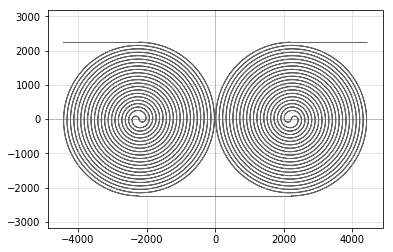

In [7]:
D = Device('archemedes_spiral')
D_b = Device('label')

width = 1.5
xs = 50
ys = 90
kw = {'width': 1.5,
     'layer': 1,
     'angle_resolution': 0.5}

AP = Device('unit_ap')
APC = AP << ph.archimedes(n=10,**kw,bent=100,distance=100)
APR = AP << ph.extend(port=APC.ports[2],length=APC.xmax+20)
APL = AP << ph.extend(port=APC.ports[1],length=APC.xmax+20)
AP.xmax=0
APsym = pg.copy(AP).reflect([0,0], [0,1])
APsym.xmin=0
AP << APsym 
D << AP

def add_asp():
    global AP
    APcopy = pg.copy(AP)
    APcopy.xmin=AP.xmax
    AP = APcopy
    return D << APcopy

# add_asp()
# add_asp()
D_out = pg.outline(D,distance=16,layer=31)
D_out << D_b

D_out.flatten().write_gds('archemedes_spiral.gds')
qp(D)

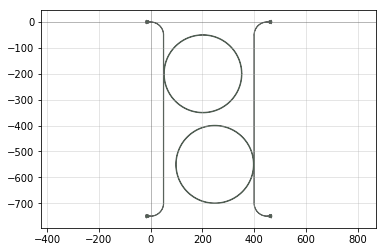

In [4]:
D = Device('PG')

args = {'width': 1}
pitch = 250*3

WG = Device('WG')
bt1 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(90).move((0,-50))
WG << ph.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args)

bt2 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(180).move((0,50-pitch))
WG << ph.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args).movey(-pitch)

bus = WG << pr.route_basic(port1=bt2.ports[1],port2=bt1.ports[2])

WG1 = D << pg.copy(WG).reflect([0,0], [0,1])
WG2 = D << pg.copy(WG).movex(450)

rg = pg.ring(150, 2).movey(-200)

RG1 = D << pg.copy(rg)
RG1.xmin = WG1.xmax + 0.4

RG2 = D << pg.copy(rg).movey(-350)
RG2.xmax = WG2.xmin - 0.5


# D_out = pg.outline(D, distance = 14)


qp(D)
# qp(D_out)
# D_out.write_gds('arc_gc.gds')
# D.xmax-D.xmin
# D.write_gds('arc_graitng.gds')

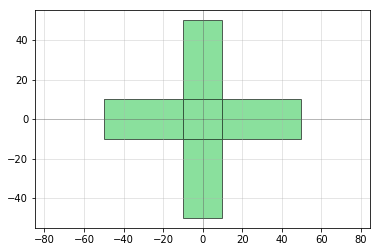

'view.gds'

In [15]:
D = Device('AD-MRR')

# D << pg.compass_multi(size=(10,10))
D << pg.cross(length=100,width=20)
# D << pg.taper()
qp(D)

D.write_gds('view.gds')

In [193]:
?pg.tee

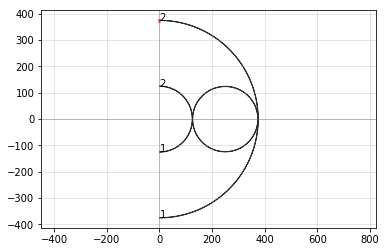

In [5]:
D = Device('AD-MRR')

w = 1
pitch = 250
gap = 0

ra1 = pitch/2
ra2 = 3*pitch/2
r = (ra2 - ra1)/2 - gap - w

args = {'width': w,
        'layer': 0}
arc1 = D << pg.arc(radius=ra1,start_angle=-90,theta=180,**args)
arc2 = D << pg.arc(radius=ra2,start_angle=-90,theta=180,**args)
rg = D << ph.ring(radius=r,**args,angle_resolution=1).move((r+ra1+gap+w,0))

# bus = D << ph.waveguide(length=100,**args)

# D << pg.deepcopy(bus) 
qp(D)

D.write_gds('templates/AD-MRR.gds')

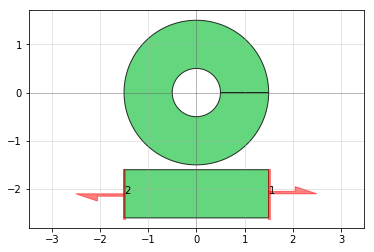

In [16]:
def allpass(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D

def fourport(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS1 = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    BUS2 = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS1.ymax = RG.ymin - gap
    BUS2.ymin = RG.ymax + gap    
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    D.add_port(name = 3, midpoint = [D.xmax,D.ymax-width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 4, midpoint = [D.xmin,D.ymax-width_bus/2], width = width_bus, orientation = 180)
    return D

# def fourport()

D = Device('view')
D << allpass(radius=1)
qp(D)
# D.write_gds('view.gds')

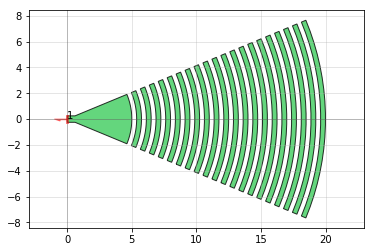

In [3]:
D = Device('PG')

D << pg.arc(radius=10,start_angle=0,theta=90,width=2)
D << ph.arc_grating()
qp(D)
D.write_gds('arc_gc.gds')
# D.write_gds('arc_graitng.gds')

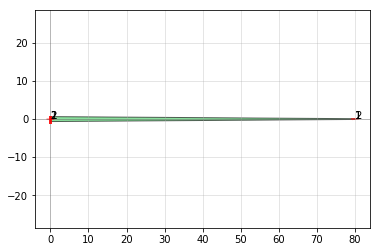

In [23]:
D = Device('mode_converter')

length = 80
CT1 = D << pg.connector(width=0.2).movex(length)
CT2 = D << pg.connector(width=1.3)
TP = D << pr.route_basic(port1=CT1.ports[1],port2=CT2.ports[2])

qp(D)
# D.write_gds('inverse_taper.gds')

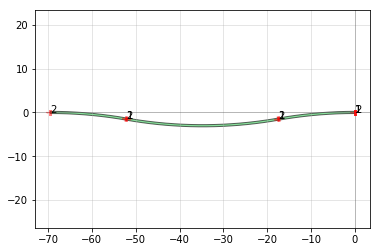

In [47]:
D = Device('bus')

wg1 = D << pg.connector(width=0.5)
arc1 = D << pg.turn(wg1.ports[2],angle=10,radius=100,angle_resolution=1)
arc2 = D << pg.turn(arc1.ports[2],angle=-20,radius=100,angle_resolution=1)
arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)
# wg2 = D << waveguide(0.5,20)
qp(D)
# D.write_gds('view.gds')

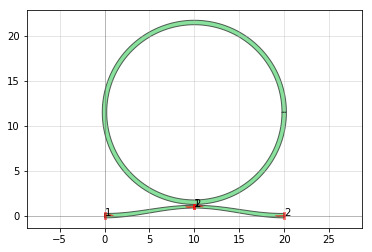

'view.gds'

In [34]:
D = Device('bus')

# gt1 = D << ph.arc_grating().rotate(180)
a1 = pg.connector((0,0),0.5)
a2 = pg.connector((10,1),0.3)
a3 = pg.connector((20,0),0.5)

w1 = D << pr.route_basic(port1=a1.ports[2],port2=a2.ports[1])
w2 = D << pr.route_basic(port1=a2.ports[2],port2=a3.ports[1])
rg = D << pg.ring(radius=10, width=0.5).move((10,12))

rg.ymin = w1.ymax + 0.1
qp(D)
D.write_gds('view.gds')